In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install torch
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.3 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import json
import pandas as pd
from tqdm import trange


def read_data(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]

    dataset = []
    for item in data:
        if 'gold_label' in item and item['gold_label'] != '-':
            premise = item['sentence1']
            hypothesis = item['sentence2']
            label = item['gold_label']
            dataset.append({'premise': premise, 'hypothesis': hypothesis, 'label': label})

    return dataset


class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {'contradiction': 0, 'neutral': 1, 'entailment': 2}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        prompt_sentence = 'Given pair of contexts (the Premise and the Hypothesis): the task is to predict whether the hypothesis is Entailed (i.e. always true), Contradicted (i.e. always false), or Neutral (neither entailed nor contradicted) given the premise.'
        encoding = self.tokenizer(prompt_sentence, 
                                  item['premise'], 
                                  item['hypothesis'], 
                                  padding='max_length', 
                                  max_length=self.max_length, 
                                  truncation=True, 
                                  return_tensors='pt')
        input_ids = encoding['input_ids'][0]
        attention_mask = encoding['attention_mask'][0]
        label_id = self.label_map[item['label']]
        return input_ids, attention_mask, label_id

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, label_id = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            label_id = label_id.to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=label_id)
            loss = outputs.loss
            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, dim=1)
            total_correct += torch.sum(predicted == label_id).item()
    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

In [ ]:
# Matched Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_matched = read_data('gdrive/MyDrive/5002_Final_Project_Data/dev_matched_sampled-1.jsonl')
dataset_matched = NLIDataset(data_matched, tokenizer, max_length=128)
dataloader_matched = DataLoader(dataset_matched, batch_size=8, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

val_loss, val_acc = evaluate(model, dataloader_matched, criterion, device)
print('Val Loss:', val_loss, 'Val Acc:', val_acc)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Val Loss: 1.0996063657395252 Val Acc: 0.36097560975609755


In [ ]:
# Mismatched Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_mismatched = read_data('gdrive/MyDrive/5002_Final_Project_Data/dev_mismatched_sampled-1.jsonl')
dataset_mismatched = NLIDataset(data_mismatched, tokenizer, max_length=128)
dataloader_mismatched = DataLoader(dataset_mismatched, batch_size=8, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

val_loss, val_acc = evaluate(model, dataloader_mismatched, criterion, device)
print('Val Loss:', val_loss, 'Val Acc:', val_acc)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Val Loss: 1.1205565292726865 Val Acc: 0.3104707792207792


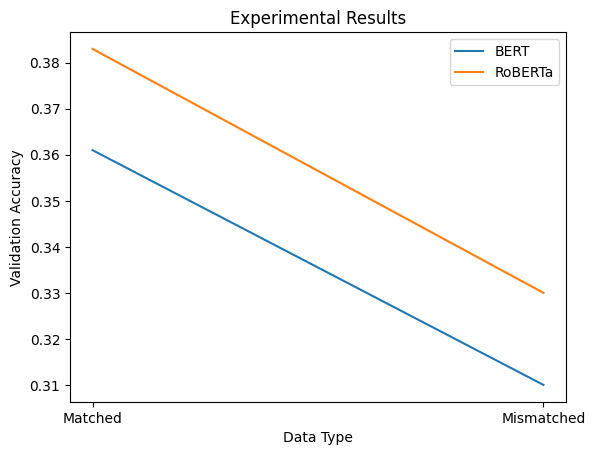

In [ ]:
import matplotlib.pyplot as plt

# Define the data
models = ['BERT', 'RoBERTa']
data_types = ['Matched', 'Mismatched']
accuracies = [
    [0.361, 0.310],
    [0.383, 0.330]
]

# Create the plot
fig, ax = plt.subplots()
for i, model in enumerate(models):
    ax.plot(data_types, accuracies[i], label=model)

# Add labels and legend
ax.set_xlabel('Data Type')
ax.set_ylabel('Validation Accuracy')
ax.set_title('Experimental Results')
ax.legend()

# Show the plot
plt.show()